In [1]:
import pandas as pd

import tqdm
from collections import defaultdict
import re
import matplotlib.pyplot as plt
import numpy as np
import gc

import category_encoders as ce

import matplotlib
import japanize_matplotlib
import seaborn as sns

import mojimoji
import itertools

# 所在地→緯度経度
import geocoder

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [3]:
train.head(3)

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間
0,1,75000,東京都北区滝野川３丁目,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,1K,9年9ヶ月,南東,20.01m2,1階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,RC（鉄筋コンクリート）,2年間
1,2,76000,東京都中央区月島３丁目,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,1R,44年10ヶ月,NaN,16.5m2,5階／10階建,専用トイレ／\tシャワー／\t温水洗浄便座,ガスコンロ／\tシステムキッチン\t／\t給湯,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 1283m,鉄骨造,2年間
2,3,110000,東京都渋谷区笹塚２丁目,京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...,1K,8年6ヶ月,南,22.05m2,12階／15階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ,エアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフローリング...,"駐輪場\t空有\tバイク置き場\t空有\t駐車場\t近隣\t30,000円(税込)\t距離100m",【スーパー】 89m\t【コンビニ】 184m\t【コンビニ】 392m\t【スーパー】 492m,RC（鉄筋コンクリート）,2年間


In [4]:
test.head(3)

,id,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間
0,31471,東京都世田谷区深沢５丁目1-27,東急大井町線\t等々力駅\t徒歩15分\t\t東急田園都市線\t桜新町駅\t徒歩24分\t\...,2LDK,49年0ヶ月,南,50.22m2,8階／8階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t温水洗浄便座／...,ガスコンロ／\tコンロ3口／\tシステムキッチン\t／\t給湯／\tL字キッチン,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\tエレベーター\t公営水...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【コンビニ】 74m\t【スーパー】 215m\t【病院】 313m\t【小学校】 219m...,鉄骨造,NaN
1,31472,東京都目黒区八雲１丁目11-8,東急東横線\t都立大学駅\t徒歩6分\t\t東急東横線\t自由が丘駅\t徒歩17分\t\t東...,1R,0年2ヶ月,南東,20.88m2,3階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCSアンテナ／\tBSアンテナ／\tインターネット使用料無料,エアコン付\tシューズボックス／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水／...,"駐車場\t近隣\t34,000円(税込)\t距離200m\t駐輪場\t無\tバイク置き場\t無",【スーパー】 128m\t【スーパー】 313m\t【コンビニ】 374m\t【コンビニ】 ...,RC（鉄筋コンクリート）,2年間
2,31473,東京都豊島区池袋本町２丁目22-2,東武東上線\t北池袋駅\t徒歩10分\t\t埼京線\t板橋駅\t徒歩16分\t\t山手線\t...,1K,23年4ヶ月,南東,26.93m2,1階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座,ガスコンロ／\t給湯,インターネット対応／\t光ファイバー／\tCATV,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t2面採光／\t室内洗濯...,"駐車場\t空有\t5,000円(税込)\t(敷金あり\t1ヶ月)\t駐輪場\t空有\tバイク...",【スーパー】 529m\t【スーパー】 810m\t【コンビニ】 316m\t【コンビニ】 ...,鉄骨造,2年間


In [5]:
# 件数確認
train.shape, test.shape

((31470, 17), (31262, 16))

# タイプミス修正

In [7]:
train_fix = [
    [3335, '所在地', '東京都中央区晴海２丁目２－２－４２', '東京都中央区晴海２丁目２－４２'],
    [7089, '所在地', '東京都大田区池上８丁目8-6-2', '東京都大田区池上８丁目6-2'],
    [7492, '面積', '5.83m2', '58.3m2'],
    [9483, '所在地', '東京都世田谷区太子堂一丁目', '東京都世田谷区太子堂1丁目'],
    [19366, '所在地', '東京都大田区池上８丁目8-6-2', '東京都大田区池上８丁目6-2'],
    [20232, '築年数', '520年5ヶ月', '20年5ヶ月'],
    [20428, '築年数', '1019年7ヶ月', '19年7ヶ月'],
    [20888, '所在地', '東京都大田区本羽田一丁目', '東京都大田区本羽田1丁目'],
    [20927, '面積', '430.1m2', '43.1m2'],
    [21286, '所在地', '東京都北区西ケ原３丁目西ヶ原３丁目', '東京都北区西ケ原３丁目'],
    [22250, '所在地', '東京都中央区晴海２丁目２－２－４２', '東京都中央区晴海２丁目２－４２'],
    [22884, '所在地', '東京都新宿区下落合２丁目2-1-17', '東京都新宿区下落合２丁目1-17'],
    [27199, '所在地', '東京都中央区晴海２丁目２－２－４２', '東京都中央区晴海２丁目２－４２'],
    [28141, '所在地', '東京都北区西ケ原１丁目西ヶ原１丁目', '東京都北区西ケ原１丁目']
]

In [8]:
for idx, col, prev, new in train_fix:
    print(idx-1, col, train.loc[idx-1, col], '->', new)
    train.loc[idx-1, col] = new

3334 所在地 東京都中央区晴海２丁目２－２－４２ -> 東京都中央区晴海２丁目２－４２
7088 所在地 東京都大田区池上８丁目8-6-2 -> 東京都大田区池上８丁目6-2
7491 面積 5.83m2 -> 58.3m2
9482 所在地 東京都世田谷区太子堂一丁目 -> 東京都世田谷区太子堂1丁目
19365 所在地 東京都大田区池上８丁目8-6-2 -> 東京都大田区池上８丁目6-2
20231 築年数 520年5ヶ月 -> 20年5ヶ月
20427 築年数 1019年7ヶ月 -> 19年7ヶ月
20887 所在地 東京都大田区本羽田一丁目 -> 東京都大田区本羽田1丁目
20926 面積 430.1m2 -> 43.1m2
21285 所在地 東京都北区西ケ原３丁目西ヶ原３丁目 -> 東京都北区西ケ原３丁目
22249 所在地 東京都中央区晴海２丁目２－２－４２ -> 東京都中央区晴海２丁目２－４２
22883 所在地 東京都新宿区下落合２丁目2-1-17 -> 東京都新宿区下落合２丁目1-17
27198 所在地 東京都中央区晴海２丁目２－２－４２ -> 東京都中央区晴海２丁目２－４２
28140 所在地 東京都北区西ケ原１丁目西ヶ原１丁目 -> 東京都北区西ケ原１丁目


<AxesSubplot:ylabel='Frequency'>

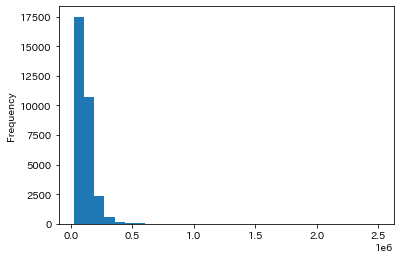

In [9]:
train["賃料"].plot.hist(bins=30)

<AxesSubplot:ylabel='Frequency'>

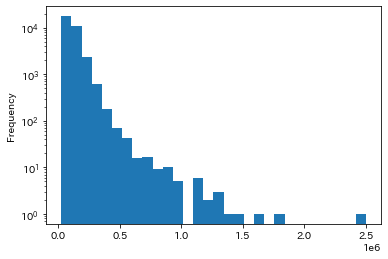

In [10]:
train["賃料"].plot.hist(bins=30, logy=True)

# Null値確認
- testの所在階のnull以外は同じカラムなので、いったん無視。→あとで補完方法考える
- 所在階nullは所在地から見ると、戸建てっぽい

In [11]:
train.isnull().sum()

id           0
賃料           0
所在地          0
アクセス         0
間取り          0
築年数          0
方角        2749
面積           0
所在階          0
バス・トイレ     329
キッチン       621
放送・通信     3440
室内設備        82
駐車場       5287
周辺環境      9432
建物構造         0
契約期間      7120
dtype: int64

In [12]:
test.isnull().sum()

id           0
所在地          0
アクセス         0
間取り          0
築年数          0
方角        2808
面積           0
所在階          1
バス・トイレ     320
キッチン       635
放送・通信     3454
室内設備        73
駐車場       5356
周辺環境      9241
建物構造         0
契約期間      6981
dtype: int64

In [13]:
test[test["所在階"].isnull()==True]

,id,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間
9204,40675,東京都江戸川区宇喜田町1469-35,都営新宿線\t船堀駅\t徒歩11分\t\t東西線\t西葛西駅\t徒歩20分\t\t東西線\t...,3LDK,0年4ヶ月,南西,94.91m2,NaN,バス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t／\t温水洗浄便座／\t洗面台...,システムキッチン\t／\tL字キッチン,NaN,バルコニー／\tルーフバルコニー\t／\tフローリング,NaN,NaN,鉄骨造,2年間


In [14]:
# 件数確認
train.shape, test.shape

((31470, 17), (31262, 16))

In [15]:
# Null値補完

# 前処理

In [16]:
def parse_etc(text):
    if text != text:
        return set()
    text = mojimoji.zen_to_han(text, kana=False)
    text = text.replace('/', '')
    vals = set(text.split('\t'))
    vals -= {''}
    return vals

def encode_etc(text, valset):
    valset = np.array(valset)
    vals = np.array(list(parse_etc(text)))
    if len(vals) == 0:
        return np.full(len(valset), 9, dtype=np.uint8)
    return np.isin(valset, vals).astype(np.uint8)

In [17]:
train_and_test = pd.concat([train,test],axis=0)

# 所在地

In [18]:
def get_address(df):
    location = df["所在地"].str.replace("東京都","").str.split("区", expand=True).rename(columns={0:"区", 1:"番地"})
    # 元のデータと結合し、不要になった所在地と詳細住所を削除
    df = pd.concat([df, location],axis=1)

    # 区情報の数値化(label encoding)
    labels, uniques = pd.factorize(df['区'])
    df['区'] = labels
    return df

In [19]:
train_tmp = get_address(train_and_test)
train_tmp[["所在地", "区", "番地"]]

,所在地,区,番地
0,東京都北区滝野川３丁目,0,滝野川３丁目
1,東京都中央区月島３丁目,1,月島３丁目
2,東京都渋谷区笹塚２丁目,2,笹塚２丁目
3,東京都杉並区高円寺南２丁目23-2,3,高円寺南２丁目23-2
4,東京都葛飾区金町３丁目7-2,4,金町３丁目7-2
...,...,...,...
31257,東京都豊島区上池袋４丁目,16,上池袋４丁目
31258,東京都千代田区岩本町２丁目,22,岩本町２丁目
31259,東京都中野区江古田３丁目14-3,15,江古田３丁目14-3
31260,東京都千代田区二番町,22,二番町


# 築年数

In [20]:
def get_age_text(text):
    if text == '新築':
        return 0.0
    try:
        year_tmp = re.search(r'\d+年', text)
        month_tmp = re.search(r'\d+ヶ月', text)
    except:
        return np.nan
    if year_tmp:
        year = int(year_tmp.group()[:-1])
    else:
        year = 0
    if month_tmp:
        month = int(month_tmp.group()[:-2])
    else:
        month = 0
    return year + month / 12

def get_age(df):
    values = df["築年数"].values
    ages = []
    for text in values:
        ages.append(get_age_text(text))
    if len(ages) != len(df):
        return "築年数error"
    df["age"] = ages
    df["age_round"] = df["age"].round()
    
    df = df.drop("築年数", axis=1)
    
    return df

In [21]:
train_tmp = get_age(train_and_test)
train_tmp[["age"]]

,age
0,9.750000
1,44.833333
2,8.500000
3,29.333333
4,31.583333
...,...
31257,0.083333
31258,15.500000
31259,1.000000
31260,15.333333


# 所在階

In [22]:
def get_floor(df):
    # NaN埋めし、「地下」を「-」に変換
    df['所在階'] = df['所在階'].fillna("不明").str.replace("地下","-")

    # まずは「X」階／「Y」階建の表記になっているレコードを変換
    train_and_test_match = df[df['所在階'].str.match("[\-0-9]+階／[\-0-9]+階建")].copy()
    floors_match = train_and_test_match['所在階'].str.extract('(?P<floor>[\-0-9]+)階／(?P<all_floor>[\-0-9]+)階建')
    train_and_test_match = pd.concat([train_and_test_match,floors_match],axis=1)

    # 上の表記になっていない(すなわち、どちらかの情報が欠損している)レコードを抽出
    train_and_test_unmatch = df[~df['所在階'].str.match("[\-0-9]+階／[\-0-9]+階建")].copy()

    # 「Y」階建だけの表記になっているレコードを変換
    train_and_test_unmatch_0 = train_and_test_unmatch[train_and_test_unmatch['所在階'].str.contains('階建')].copy()
    floors_unmatch_0 = train_and_test_unmatch_0['所在階'].str.extract('(?P<all_floor>[\-0-9]+)階建')
    train_and_test_unmatch_0 = pd.concat([train_and_test_unmatch_0,floors_unmatch_0],axis=1)

    # 「X」階だけの表記になっているレコードを変換
    train_and_test_unmatch_1 = train_and_test_unmatch[~train_and_test_unmatch['所在階'].str.contains('階建')].copy()
    floors_unmatch_1 = train_and_test_unmatch_1['所在階'].str.extract('(?P<floor>[\-0-9]+)階')
    train_and_test_unmatch_1 = pd.concat([train_and_test_unmatch_1,floors_unmatch_1],axis=1)

    df = pd.concat([train_and_test_match,train_and_test_unmatch_0,train_and_test_unmatch_1],axis=0)
    # 「X」階、「Y」階建どちらの情報もNaNになっているレコードは1つしかないはず。
    # 2つ以上あると変換ミスが起きていることになるので、1つしかないことを確認
    print(len(df[(df["floor"].isnull())&(df["all_floor"].isnull())]))

    df = df.drop('所在階', axis=1)

    # 数値型に変換する。NaNが入っていると変換できないので、一度適当な値で埋めて変換する
    df['floor'] = df['floor'].fillna(99999)
    df['all_floor'] = df['all_floor'].fillna(99999)
    df = df.astype({'floor':"int16",'all_floor':"int16"})
    #「X」階 = floor の値が負になっているレコードを一律-1に設定
    df.loc[df['floor']<0,'floor'] = -1
    df.loc[df['all_floor']<0,'all_floor'] = -1
    # 99999をNaNに戻す
    df['floor'] = df['floor'].replace(99999,np.nan)
    df['all_floor'] = df['all_floor'].replace(99999,np.nan)
    
    return df

In [23]:
train_tmp = get_floor(train_and_test)
train_tmp[["floor", "all_floor"]]

1


,floor,all_floor
0,1,12
1,5,10
2,12,15
3,3,4
4,1,2
...,...,...
25994,2,-1
26224,1,-1
26506,3,-1
29127,3,-1


# 契約期間

In [24]:
def get_contr(df):
    # NaNがあると動かない処理が多くあるので、最初にNaNを適当な値で埋める
    df['契約期間'] = df['契約期間'].fillna("不明")

    # 定期借家か否かのフラグ (True/Falseで出てくるので1/0に変換)
    df['定期借家フラグ'] = df['契約期間'].str.contains("定期借家").map({False:0,True:1})

    # まずは「X」年「Yヶ月」間 表記になっているレコードのX, Yを抽出
    train_and_test_keiyaku1 = df[df['契約期間'].str.match("[0-9]+年[0-9+]ヶ月間")].copy()
    keiyaku_year_month = train_and_test_keiyaku1['契約期間'].str.extract('(?P<契約_year>[0-9]+)年(?P<契約_month>[0-9]+)ヶ月間')
    keiyaku_year_month = keiyaku_year_month.astype({'契約_year':"int8",'契約_month':"int8"})
    # 月を年に換算して合算
    keiyaku_year_month['keiyaku_length'] = keiyaku_year_month['契約_year']+(keiyaku_year_month['契約_month']/12.0)
    # 元のデータフレームのidと結合(idはマージ用)
    train_and_test_keiyaku1 = pd.concat([train_and_test_keiyaku1[['id']],keiyaku_year_month[['keiyaku_length']]],axis=1)

    # 「X」年「Yヶ月」間 表記になっておらず、かつ「A年B月まで」表記にもなっていないレコードを抽出
    train_and_test_keiyaku2 = df[(~df['契約期間'].str.match("[0-9]+年[0-9+]ヶ月間"))&(~df['契約期間'].str.contains("まで"))].copy()

    # 「X」年間 表記になっているレコードを変換
    train_and_test_keiyaku2_year = train_and_test_keiyaku2[train_and_test_keiyaku2['契約期間'].str.match("[0-9]+年間")].copy()
    keiyaku_year = train_and_test_keiyaku2_year['契約期間'].str.extract('(?P<keiyaku_length>[0-9]+)年間')
    keiyaku_year = keiyaku_year.astype({'keiyaku_length':"int8"})
    train_and_test_keiyaku2_year = pd.concat([train_and_test_keiyaku2_year[['id']],keiyaku_year],axis=1)
    # 「Y」ヶ月間 表記になっているレコードを変換
    train_and_test_keiyaku2_month = train_and_test_keiyaku2[train_and_test_keiyaku2['契約期間'].str.match("[0-9]+ヶ月間")].copy()
    keiyaku_month = train_and_test_keiyaku2_month['契約期間'].str.extract('(?P<keiyaku_length>[0-9]+)ヶ月間')
    keiyaku_month = keiyaku_month.astype({'keiyaku_length':"float32"})
    # 月を年に換算
    keiyaku_month['keiyaku_length'] /= 12.0
    train_and_test_keiyaku2_month = pd.concat([train_and_test_keiyaku2_month[['id']],keiyaku_month],axis=1)

    # 「A年B月まで」表記にもなっているレコードを抽出 & 変換
    train_and_test_keiyaku3 = df[df['契約期間'].str.contains("まで")].copy()
    keiyaku_until = train_and_test_keiyaku3['契約期間'].str.extract('(?P<年>[0-9]+)年(?P<月>[0-9]+)月まで')
    keiyaku_until = keiyaku_until.astype({'年':"int16",'月':"int8"})
    # 2019年8月を起点に引き算した後に年換算
    keiyaku_until['keiyaku_length'] = ((keiyaku_until['年']-2019)*12+(keiyaku_until['月']-8))/12.0
    train_and_test_keiyaku3 = pd.concat([train_and_test_keiyaku3[['id']],keiyaku_until[['keiyaku_length']]],axis=1)

    # 加工したデータフレームを結合
    train_and_test_keiyaku = pd.concat([train_and_test_keiyaku1,train_and_test_keiyaku2_year,train_and_test_keiyaku2_month,train_and_test_keiyaku3],axis=0)
    # 元のデータフレームにマージ
    df = df.merge(train_and_test_keiyaku,on='id',how="left")
    df = df.drop('契約期間', axis=1)
    
    return df

In [25]:
train_tmp = get_contr(train_and_test)
train_tmp[["keiyaku_length", "定期借家フラグ"]]

,keiyaku_length,定期借家フラグ
0,2.0,0
1,2.0,0
2,2.0,0
3,2.0,1
4,2.0,0
...,...,...
62727,2.0,0
62728,NaN,0
62729,2.0,1
62730,NaN,0


# 間取り

In [26]:
def get_plan(df):
    # ↑で確認した限り、必ず1文字目が部屋数なので1文字目を取得
    df['部屋数'] = df['間取り'].map(lambda x:int(x[0]))

    # K, D, L, Sのあるなしを取得
    df['K有無'] = df['間取り'].str.contains("K").astype(int)
    df['D有無'] = df['間取り'].str.contains("D").astype(int)
    df['L有無'] = df['間取り'].str.contains("L").astype(int)
    df['S有無'] = df['間取り'].str.contains("S").astype(int)
    df = df.drop('間取り', axis=1)

    return df

In [27]:
train_tmp = get_plan(train_and_test)
train_tmp[["部屋数", "K有無", "D有無", "L有無", "S有無"]]

,部屋数,K有無,D有無,L有無,S有無
0,1,1,0,0,0
1,1,0,0,0,0
2,1,1,0,0,0
3,2,1,1,1,0
4,2,1,1,0,0
...,...,...,...,...,...
31257,1,1,0,0,0
31258,1,0,0,0,0
31259,1,1,1,1,0
31260,1,1,0,0,0


# 駐輪場、駐車場

In [28]:
def parse_park(text):
    if text != text:
        return np.full(3, 9, dtype=np.uint8)
    text = mojimoji.zen_to_han(text, kana=False)
    text = text.replace('\t', '')
    keys = re.findall(r'駐輪場|バイク置き場|駐車場', text)
    vals = re.split(r'駐輪場|バイク置き場|駐車場', text)[1:]
    assert len(keys) == len(vals)
    res = np.zeros(3, dtype=np.uint8)
    key_order = ['駐輪場', 'バイク置き場', '駐車場']
    for i, v in enumerate(vals):
        if '無' in v:
            res[key_order.index(keys[i])] = 0
        else:
            _price = re.search(r'\d+円', v)
            if _price:
                res[key_order.index(keys[i])] = 2
            elif '空有' in v:
                res[key_order.index(keys[i])] = 1
    return res


def get_park(df):
    vals = df['駐車場'].values
    new_df = []
    for i, val in enumerate(vals):
        new_df.append(parse_park(val))
    new_df = pd.DataFrame(new_df, index=df.index,
                          columns=['park_bike', 'park_motor', 'park_car'])
    df = pd.concat([df, new_df], axis=1)
    df = df.drop('駐車場', axis=1)
    return df

In [29]:
train_tmp = get_park(train_and_test)
train_tmp[["park_bike", "park_motor", "park_car"]]

,park_bike,park_motor,park_car
0,1,0,0
1,1,0,0
2,1,1,2
3,0,0,0
4,0,0,2
...,...,...,...
31257,0,0,0
31258,1,0,2
31259,1,0,2
31260,1,0,0


# 面積

In [30]:
def get_area(df):
    df["area"] = df["面積"].str.replace("m2", "").astype(float)
    df["area_round"] = df["area"].round()
    df = df.drop("面積", axis=1)
    return df

# 風呂・トイレ

In [31]:
def get_bus_toilet(df):
    valset = {'トイレなし', '共同トイレ', '専用バス', '脱衣所', 'バス・トイレ別',
              '専用トイレ', 'シャワー', '洗面台独立', '共同バス', '浴室乾燥機',
              '追焚機能', '温水洗浄便座', 'バスなし'}
    valset = sorted(valset)
    vals = df['バス・トイレ'].values
    new_df = []
    for i, val in enumerate(vals):
        new_df.append(encode_etc(val, valset))
    new_df = pd.DataFrame(new_df, index=df.index, columns=list(valset))
    df = pd.concat([df, new_df], axis=1)
    df = df.drop('バス・トイレ', axis=1)
    
    return df

# 周辺環境

In [32]:
def encode_env(text, valset):
    # 近いほどいいので、適当にでかい値を入れておく
    items = parse_etc(text)
    if len(items) == 0:
        return np.full(len(valset), 99999)
    dists = np.full(len(valset), 99999)
    for item in items:
        place = re.search(r'【.{1,9}】', item).group()
        idx = valset.index(place)
        dist = int(re.search(r'\d+', item).group())
        if dist < dists[idx]:
            dists[idx] = dist
    return dists

def get_env(df):
    valset = {'【銀行】', '【コンビニ】', '【小学校】', '【総合病院】', '【大学】',
              '【図書館】', '【デパート】', '【公園】', '【幼稚園・保育園】',
              '【コインパーキング】', '【クリーニング】', '【レンタルビデオ】',
              '【学校】', '【ドラッグストア】', '【月極駐車場】', '【スーパー】',
              '【病院】', '【飲食店】', '【郵便局】'}
    valset = sorted(valset)
    vals = df['周辺環境'].values
    new_df = []
    for i, val in enumerate(vals):
        new_df.append(encode_env(val, valset))
    new_df = pd.DataFrame(new_df, index=df.index, columns=list(valset))
    df = pd.concat([df, new_df], axis=1)
    df = df.drop('周辺環境', axis=1)
    
    return df

In [33]:
val = ['【デパート】',
       '【総合病院】',
       '【図書館】',
       '【コンビニ】',
       '【公園】',
       '【ドラッグストア】',
       '【銀行】',
       '【月極駐車場】',
       '【大学】',
       '【クリーニング】',
       '【幼稚園・保育園】',
       '【レンタルビデオ】',
       '【スーパー】',
       '【学校】',
       '【小学校】',
       '【コインパーキング】',
       '【病院】',
       '【飲食店】',
       '【郵便局】',
      ]
train_tmp = get_env(train_and_test)
train_tmp[val]

,【デパート】,【総合病院】,【図書館】,【コンビニ】,【公園】,【ドラッグストア】,【銀行】,【月極駐車場】,【大学】,【クリーニング】,【幼稚園・保育園】,【レンタルビデオ】,【スーパー】,【学校】,【小学校】,【コインパーキング】,【病院】,【飲食店】,【郵便局】
0,99999,99999,99999,588,1103,956,99999,99999,461,99999,99999,99999,311,99999,495,99999,99999,378,1246
1,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,1283,99999,99999,99999,99999,99999,99999
2,99999,99999,99999,184,99999,99999,99999,99999,99999,99999,99999,99999,89,99999,99999,99999,99999,99999,99999
3,99999,99999,99999,326,99999,99999,99999,99999,99999,99999,99999,99999,225,99999,99999,99999,99999,99999,99999
4,99999,99999,99999,351,99999,99999,99999,99999,99999,99999,99999,99999,193,99999,99999,99999,99999,99999,99999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31257,99999,99999,99999,204,99999,99999,99999,99999,99999,99999,99999,99999,284,99999,99999,99999,99999,99999,99999
31258,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999
31259,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999
31260,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999,99999


# 室内設備

In [34]:
def get_interior(df):
    valset = {'バルコニー', '井戸', 'ルーフバルコニー', 'ガス暖房', '室内洗濯機置場',
              '汲み取り', 'シューズボックス', 'エレベーター', '室外洗濯機置場', 'エアコン付',
              'バリアフリー', 'プロパンガス', '浄化槽', '床暖房', 'ロフト付き', 'フローリング',
              '専用庭', '石油暖房', '3面採光', 'クッションフロア', '公営水道', 'ガスその他',
              '出窓', '冷房', '水道その他', '防音室', '都市ガス', '下水', 'オール電化',
              '二世帯住宅', 'ウォークインクローゼット', '敷地内ごみ置き場', 'トランクルーム',
              '24時間換気システム', '排水その他', 'タイル張り', '2面採光', '二重サッシ',
              '床下収納', '地下室', '洗濯機置場なし', 'ペアガラス'}
    valset = sorted(valset)
    vals = df['室内設備'].values
    new_df = []
    for i, val in enumerate(vals):
        new_df.append(encode_etc(val, valset))
    new_df = pd.DataFrame(new_df, index=df.index, columns=list(valset))
    df = pd.concat([df, new_df], axis=1)
    df = df.drop('室内設備', axis=1)
    
    return df

In [35]:
val = ['出窓',
 '水道その他',
 '専用庭',
 '下水',
 'シューズボックス',
 '排水その他',
 '室外洗濯機置場',
 'クッションフロア',
 '二重サッシ',
 'バルコニー',
 'エレベーター',
 '敷地内ごみ置き場',
 '床下収納',
 '二世帯住宅',
 '室内洗濯機置場',
 '床暖房',
 '2面採光',
 'ルーフバルコニー',
 '公営水道',
 '井戸',
 '24時間換気システム',
 'ガス暖房',
 '浄化槽',
 'バリアフリー',
 'フローリング',
 'ペアガラス',
 'ガスその他',
 '洗濯機置場なし',
 'エアコン付',
 '防音室',
 'ウォークインクローゼット',
 'オール電化',
 '汲み取り',
 'プロパンガス',
 '石油暖房',
 '3面採光',
 'ロフト付き',
 '地下室',
 'トランクルーム',
 '冷房',
 '都市ガス',
 'タイル張り'
      ]

train_tmp = get_interior(train_and_test)
train_tmp[val]

,出窓,水道その他,専用庭,下水,シューズボックス,排水その他,室外洗濯機置場,クッションフロア,二重サッシ,バルコニー,...,汲み取り,プロパンガス,石油暖房,3面採光,ロフト付き,地下室,トランクルーム,冷房,都市ガス,タイル張り
0,0,0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1
3,0,0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31257,0,0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1
31258,0,0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,1
31259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31260,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,1


In [36]:
def get_kitchen(df):
    valset = {'ガスコンロ', '冷蔵庫あり', 'コンロ設置可(コンロ4口以上)', 'カウンターキッチン',
              'IHコンロ', 'コンロ設置可(コンロ1口)', 'コンロ設置可(コンロ3口)', 'コンロ3口',
              '電気コンロ', 'コンロ設置可(口数不明)', 'L字キッチン', '独立キッチン', '給湯',
              'コンロ4口以上', 'コンロ2口', 'システムキッチン', 'コンロ1口', 'コンロ設置可(コンロ2口)'}
    valset = sorted(valset)
    vals = df['キッチン'].values
    new_df = []
    for i, val in enumerate(vals):
        new_df.append(encode_etc(val, valset))
    new_df = pd.DataFrame(new_df, index=df.index, columns=list(valset))
    df = pd.concat([df, new_df], axis=1)
    df = df.drop('キッチン', axis=1)

    return df

In [37]:
def get_tv(df):
    valset = {'BSアンテナ', '光ファイバー', 'CSアンテナ', '高速インターネット', 'CATV',
              '有線放送', 'インターネット対応', 'インターネット使用料無料'}
    valset = sorted(valset)
    vals = df['放送・通信'].values
    new_df = []
    for i, val in enumerate(vals):
        new_df.append(encode_etc(val, valset))
    new_df = pd.DataFrame(new_df, index=df.index, columns=list(valset))
    df = df.merge(new_df, left_index=True, right_index=True)
    df = df.drop('放送・通信', axis=1)
    
    return df

In [38]:
def get_label(df, label):
    labels, uniques = pd.factorize(df[label])
    df[label] = labels
    return df

In [39]:
def get_access(df):
    mottime = df['アクセス'].str.split("\t", expand=True).iloc[:,2:12:4]
    mottime1 = mottime[2].str.extract('徒歩(?P<徒歩_time1>[0-9]+)分')
    mottime = pd.concat([mottime1],axis=1).fillna(0)
    
    railway = pd.DataFrame(df["アクセス"].str.split("\t", expand=True)[0])
    railway.columns = ["railway"]

    count_encoder = ce.CountEncoder(cols=['railway'])
    railway = count_encoder.fit_transform(railway)
    
    df = pd.concat([df, mottime, railway], axis=1)
#     df = df.drop("アクセス", axis=1)
    return df

In [40]:
def preprocess(df, drop_column=False):
    """
    特徴量を追加したり数値の形にする
    """
    print(f"start:{df.shape}")
    
    # 所在地
    df = get_address(df)
    print(f"所在地：{df.shape}")
    
    # 築年数
    df = get_age(df)
    print(f"築年数：{df.shape}")
    
    # 面積
    df = get_area(df)
    print(f"面積：{df.shape}")
    
    # バス・トイレ
    df = get_bus_toilet(df)
    print(f"バス・トイレ：{df.shape}")
    
    # 駐車場
    df = get_park(df)
    print(f"駐車場：{df.shape}")
    
    # 間取り
    df = get_plan(df)
    print(f"間取り：{df.shape}")
    
    # 契約期間
    df = get_contr(df)
    print(f"契約期間：{df.shape}")
    
    # 所在階
    df = get_floor(df)
    print(f"所在階：{df.shape}")
    
    # 周辺環境
    df = get_env(df)
    print(f"周辺環境：{df.shape}")
    
    # 室内設備
    df = get_interior(df)
    print(f"室内設備：{df.shape}")
    
    # キッチン
    df = get_kitchen(df)
    print(f"キッチン：{df.shape}")
    
    # TV
    df = get_tv(df)
    print(f"TV：{df.shape}")
    
    # アクセス
    df = get_access(df)
    print(f"アクセス：{df.shape}")
    
    # 方角、建物構造
    df = get_label(df, "方角")
    print(f"方角：{df.shape}")
    df = get_label(df, "建物構造")
    print(f"建物構造：{df.shape}")
    
    return df

In [41]:
train_and_test = preprocess(train_and_test)

start:(62732, 25)
所在地：(62732, 27)
築年数：(62732, 26)
面積：(62732, 27)
バス・トイレ：(62732, 39)
駐車場：(62732, 41)
間取り：(62732, 40)
契約期間：(62732, 40)
1
所在階：(62732, 41)
周辺環境：(62732, 59)
室内設備：(62732, 100)
キッチン：(62732, 117)
TV：(62732, 124)
アクセス：(62732, 126)
方角：(62732, 126)
建物構造：(62732, 126)


In [42]:
train = train_and_test[train_and_test['賃料'].notnull()].copy().reset_index(drop=True)
test = train_and_test[train_and_test['賃料'].isnull()].copy().reset_index(drop=True)

print(train.shape,test.shape)

(31470, 126) (31262, 126)


In [43]:
train.to_csv("data/train_processed.csv", index=False)
test.to_csv("data/test_processed.csv", index=False)

# 四則演算特徴量作成

In [44]:
cols = [
    'age',
    'age_round',
    '部屋数',
    'area',
    'area_round',
    'keiyaku_length',
    'floor',
    'all_floor',
]

In [45]:
def add_sub_mul_div(df, col1, col2):
    df[f"{col1}+{col2}"] = df[col1] + df[col2]
    df[f"{col1}-{col2}"] = df[col1] - df[col2]
    df[f"{col1}*{col2}"] = df[col1] * df[col2]
    df[f"{col1}/{col2}"] = df[col1] / df[col2]
    return df

In [46]:
for c in itertools.combinations(cols, 2):
    col1, col2 = list(c)
    train_and_test = add_sub_mul_div(train_and_test, col1, col2)

/tmp/ipykernel_1067/919974498.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col1}/{col2}"] = df[col1] / df[col2]
/tmp/ipykernel_1067/919974498.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col1}+{col2}"] = df[col1] + df[col2]
/tmp/ipykernel_1067/919974498.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, u

# Groupby特徴量作成

In [47]:
cols = [
    '方角',
    '建物構造',
    'age_round',
    '区',
    'area_round',
    'keiyaku_length',
    'floor',
    '徒歩_time1',
]

In [48]:
def make_groupby_from(df, groupby_col, agg_func):
    groupby_df = df.groupby(groupby_col).agg({"賃料":agg_func}).reset_index().fillna(0)
    agg_func_column = [f"{agg}_{'&'.join(groupby_col)}" for agg in agg_func]
    groupby_df.columns = groupby_col + agg_func_column
    return groupby_df

In [49]:
agg_func = ["mean", "median", "min", "max", "std"]

for c in itertools.combinations(cols, 1):
    groupby_col = list(c)
    groupby_df = make_groupby_from(train_and_test, groupby_col, agg_func)
    groupby_df[f"max-min_{'&'.join(groupby_col)}"] = groupby_df[f"max_{'&'.join(groupby_col)}"] - groupby_df[f"min_{'&'.join(groupby_col)}"]
    train_and_test = pd.merge(train_and_test, groupby_df, on=groupby_col, how="left")
print("----------------1 done----------------")
# for c in itertools.combinations(cols, 2):
#     groupby_col = list(c)
#     groupby_df = make_groupby_from(train_and_test, groupby_col, agg_func)
#     groupby_df[f"max-min_{'&'.join(groupby_col)}"] = groupby_df[f"max_{'&'.join(groupby_col)}"] - groupby_df[f"min_{'&'.join(groupby_col)}"]
#     train_and_test = pd.merge(train_and_test, groupby_df, on=groupby_col, how="left")
# print("----------------2 done----------------")
# for c in itertools.combinations(cols, 3):
#     groupby_col = list(c)
#     groupby_df = make_groupby_from(train_and_test, groupby_col, agg_func)
#     groupby_df[f"max-min_{'&'.join(groupby_col)}"] = groupby_df[f"max_{'&'.join(groupby_col)}"] - groupby_df[f"min_{'&'.join(groupby_col)}"]
#     train_and_test = pd.merge(train_and_test, groupby_df, on=groupby_col, how="left")
# print("----------------3 done----------------")

----------------1 done----------------


In [50]:
train = train_and_test[train_and_test['賃料'].notnull()].copy().reset_index(drop=True)
test = train_and_test[train_and_test['賃料'].isnull()].copy().reset_index(drop=True)
del train_and_test

train.to_csv("data/train_processed_add_groupby.csv", index=False)
test.to_csv("data/test_processed_add_groupby.csv", index=False)

gc.collect()

93

In [51]:
print(train.shape,test.shape)

(31470, 286) (31262, 286)


In [52]:
train.to_csv("data/train_processed_add_groupby.csv", index=False)
test.to_csv("data/test_processed_add_groupby.csv", index=False)